In [21]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib

%run preprocess.ipynb

==================PROSES PEMUATAN DATASET==================

[1/3] Memuat dataset_final\train
Found 1200 files belonging to 4 classes.

[2/3] Memuat dataset_final\val
Found 87 files belonging to 4 classes.

[3/3] Memuat dataset_final\test
Found 90 files belonging to 4 classes.

==================INFORMASI KELAS & MAPPING==================
Kelas ditemukan: ['1', '2', '3', '4']

Index Model     | Nama Folder     | Nilai PPB (Target)  
------------------------------------------------------------
0               | 1               | 0                   
1               | 2               | 1                   
2               | 3               | 2                   
3               | 4               | 3                   

Selesai. Dataset siap digunakan.
Step 2: Setting up data augmentation...
✓ RandomFlip (horizontal)
✓ RandomRotation (±10°)
✓ Preprocessing applied to all datasets


In [22]:
print("Step 1: Building ResNet-50 model...")

img_height = 224
img_width = 224
batch_size = 32
NUM_CLASSES = 4  # Update sesuai jumlah kelas pada dataset Anda

# Base ResNet-50 model (pre-trained on ImageNet)
base_model = ResNet50(
    weights='imagenet',  # Use pre-trained weights
    include_top=False,   # Exclude top classification layer
    input_shape=(224, 224, 3)
)

# Freeze base model initially for transfer learning
base_model.trainable = False

# Build the complete model using Functional API (more stable)
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x) #mengubah 3D menjadi vektor 1D

#------------------------------------------------------------------------------
# x = layers.Dense(64, activation='relu', name='dense_64_simplified')(x) 
# x = layers.Dropout(0.3, name='dropout_1')(x) # Pertahankan Dropout
#------------------------------------------------------------------------------
# x = layers.Dense(128, activation='relu', name='dense_128')(x)
# x = layers.Dropout(0.3, name='dropout_1')(x)
# x = layers.Dense(32, activation='relu', name='dense_32')(x) 
#------------------------------------------------------------------------------
x = layers.Dense(512, activation='relu', name='dense_512')(x)
x = layers.Dropout(0.3, name='dropout_1')(x)
x = layers.Dense(256, activation='relu', name='dense_256')(x)
x = layers.Dropout(0.3, name='dropout_2')(x)
x = layers.Dense(64, activation='relu', name='dense_64')(x)
#------------------------------------------------------------------------------

outputs = layers.Dense(NUM_CLASSES, activation='softmax', name='aflatoxin_output')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs, name='AflatoxinClassifier')

# Compile model for classification
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  
    metrics=['accuracy']  
)

print("✓ Optimizer: Adam (learning_rate=1e-4)")
print("✓ Loss: sparse_categorical_crossentropy")
print("✓ Metrics: accuracy")
print("Model compiled successfully!")
print(f"\nTotal parameters: {model.count_params():,}")

# Display model architecture
model.summary()

Step 1: Building ResNet-50 model...
✓ Optimizer: Adam (learning_rate=1e-4)
✓ Loss: sparse_categorical_crossentropy
✓ Metrics: accuracy
Model compiled successfully!

Total parameters: 24,784,836


Model: "AflatoxinClassifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_512 (Dense)               │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_64 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ aflatoxin_output (Dense)        │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,784,836 (94.55 MB)

 Trainable params: 1,197,124 (4.57 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [23]:
print("Step 2: Setting up training callbacks...")

# Training callbacks for better training control
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=15, #jumlah epoch yg ditunggu
        mode='max', #accuracy higher is better
        restore_best_weights=True, 
        verbose=1 #menampilkan pesan di konsol saat pelatihan dihentikan
    ), # Stop training if no improvement in validation loss
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5, #kurangi LR 50%
        patience=10,
        min_lr=1e-8,
        verbose=1
    ), # Reduce learning rate if no improvement
    tf.keras.callbacks.ModelCheckpoint(
        'best_aflatoxin_classifier.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    ) # Save best model
]

print("✓ EarlyStopping (monitor='val_accuracy', patience=15)")
print("✓ ReduceLROnPlateau (factor=0.5, patience=10)")
print("✓ ModelCheckpoint (save best model)")

Step 2: Setting up training callbacks...
✓ EarlyStopping (monitor='val_accuracy', patience=15)
✓ ReduceLROnPlateau (factor=0.5, patience=10)
✓ ModelCheckpoint (save best model)


In [24]:
print("Step 3: Phase 1 - Training with frozen base model...")

# Phase 1: Train with frozen base model
initial_epochs = 25

history_1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=initial_epochs,
    callbacks=callbacks,
    verbose=1
)

Step 3: Phase 1 - Training with frozen base model...
Epoch 1/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2618 - loss: 1.4326
Epoch 1: val_accuracy improved from None to 0.16092, saving model to best_aflatoxin_classifier.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 116s 3s/step - accuracy: 0.2708 - loss: 1.4086 - val_accuracy: 0.1609 - val_loss: 1.4304 - learning_rate: 1.0000e-04
Epoch 2/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3021 - loss: 1.3756
Epoch 2: val_accuracy improved from 0.16092 to 0.27586, saving model to best_aflatoxin_classifier.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.3275 - loss: 1.3512 - val_accuracy: 0.2759 - val_loss: 1.4109 - learning_rate: 1.0000e-04
Epoch 3/25
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3438 - loss: 1.3131
Epoch 3: val_accuracy did not improve from 0.27586
38/38 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - accuracy: 0.3708 - loss: 1.2937 - val_accuracy: 0.2759 - val_loss: 1.4223 - learning_rate: 1.0000e-04
Epoch 4/25

In [25]:
print("Step 4: Phase 2 - Fine-tuning...")

# --- LANGKAH PENTING: MUAT BOBOT TERBAIK DARI FASE 1 ---
try:
    # Memuat bobot terbaik yang tersimpan dari ModelCheckpoint Phase 1
    model.load_weights('best_aflatoxin_classifier.keras')
    print("✅ Bobot terbaik dari Phase 1 berhasil dimuat.")
except Exception as e:
    print(f"❌ Peringatan: Gagal memuat bobot dari best_aflatoxin_classifier.keras. Error: {e}")
    print("   Melanjutkan dengan bobot terakhir Phase 1.")
    
# Unfreeze the base model
base_model = model.layers[1]  # Asumsi base_model adalah layer pertama di model Sequential/Functional
base_model.trainable = True

# Fine-tune from this layer onwards (keep early layers frozen)
fine_tune_at = 140  # #freeze layer 0-139, 140+ train layer
# Freeze all layers before fine_tune_at
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"✓ Fine-tuning dari layer {fine_tune_at}")
print(f"✓ Total trainable layers: {len([l for l in base_model.layers if l.trainable])}")

# Recompile with lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Lower learning rate
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

# Continue training with fine-tuning
fine_tune_epochs = 30
total_epochs = initial_epochs + fine_tune_epochs

history_2 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=total_epochs,
    initial_epoch=len(history_1.history['loss']),
    callbacks=callbacks,
    verbose=1
)

Step 4: Phase 2 - Fine-tuning...
✅ Bobot terbaik dari Phase 1 berhasil dimuat.
✓ Fine-tuning dari layer 140
✓ Total trainable layers: 35
Epoch 26/55
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4139 - loss: 1.3214
Epoch 26: val_accuracy did not improve from 0.49425
38/38 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.4433 - loss: 1.2149 - val_accuracy: 0.4023 - val_loss: 1.3400 - learning_rate: 1.0000e-05
Epoch 27/55
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4957 - loss: 1.0499
Epoch 27: val_accuracy did not improve from 0.49425
38/38 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.5042 - loss: 1.0528 - val_accuracy: 0.3678 - val_loss: 1.4710 - learning_rate: 1.0000e-05
Epoch 28/55
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5674 - loss: 0.9516
Epoch 28: val_accuracy did not improve from 0.49425
38/38 ━━━━━━━━━━━━━━━━━━━━ 127s 3s/step - accuracy: 0.5633 - loss: 0.9507 - val_accuracy: 0.3103 - val_loss: 1.6096 - learning_rate: 1.0000e-05
Epoch 29/55
38/38 ━━━━━━

In [26]:
print("Step 5: Evaluation on data set...")

# Load model terbaik
model = tf.keras.models.load_model('best_aflatoxin_classifier.keras')

# Evaluasi
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"\n✓ Test Loss: {test_loss:.4f}")
print(f"✓ Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

Step 5: Evaluation on data set...
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.5222 - loss: 1.0199

✓ Test Loss: 1.0199
✓ Test Accuracy: 0.5222 (52.22%)


Step 6: Generating classification report and confusion matrix...
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step

Classification Report:
------------------------------------------------------------
              precision    recall  f1-score   support

     Kelas 1     0.5517    0.8421    0.6667        19
     Kelas 2     0.6471    0.2973    0.4074        37
     Kelas 3     0.5000    0.5000    0.5000        24
     Kelas 4     0.4000    0.8000    0.5333        10

    accuracy                         0.5222        90
   macro avg     0.5247    0.6099    0.5269        90
weighted avg     0.5603    0.5222    0.5008        90


Confusion Matrix:
[[16  3  0  0]
 [13 11 10  3]
 [ 0  3 12  9]
 [ 0  0  2  8]]


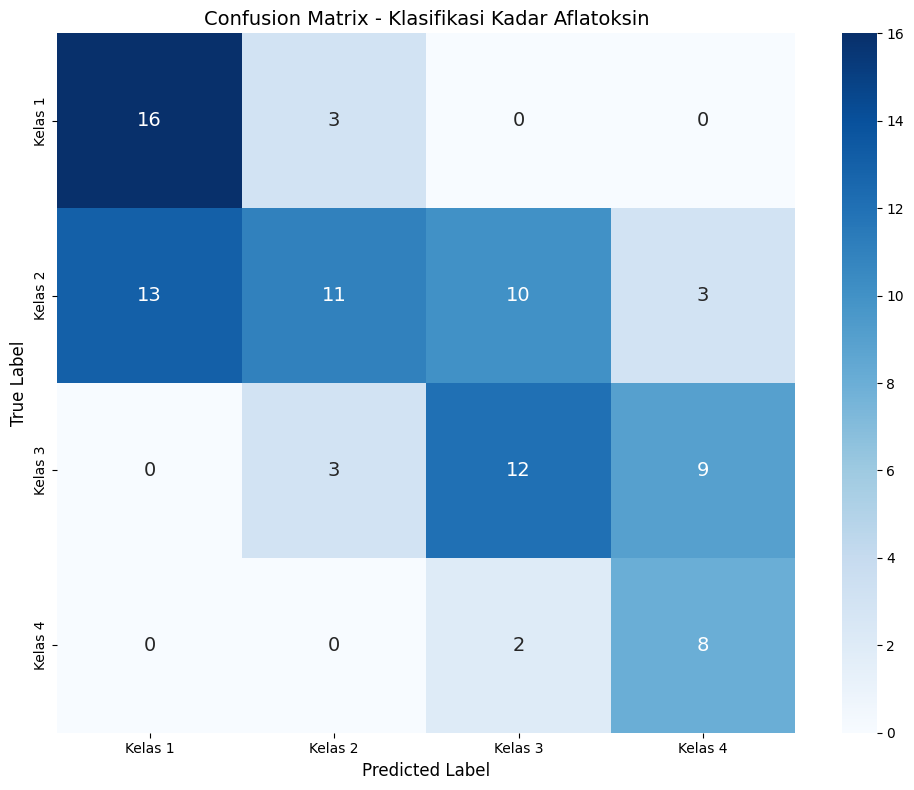


✓ Confusion matrix saved to 'confusion_matrix.png'


In [27]:
print("Step 6: Generating classification report and confusion matrix...")

# Prediksi
y_pred_probs = model.predict(test_ds, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# Ground truth
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Classification Report
# Referensi: Sokolova & Lapalme (2009)
class_names = ['Kelas 1', 'Kelas 2', 'Kelas 3', 'Kelas 4']
print("\nClassification Report:")
print("-" * 60)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            annot_kws={"size": 14})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Klasifikasi Kadar Aflatoksin', fontsize=14)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrix saved to 'confusion_matrix.png'")

In [28]:
print("Step 7: Analyzing confidence scores...")

# Confidence score adalah probabilitas tertinggi dari softmax output
confidence_scores = np.max(y_pred_probs, axis=1)

print(f"\nStatistik Confidence Score:")
print(f"  Min: {confidence_scores.min():.4f}")
print(f"  Max: {confidence_scores.max():.4f}")
print(f"  Mean: {confidence_scores.mean():.4f}")
print(f"  Std: {confidence_scores.std():.4f}")

# Prediksi dengan high confidence (>0.9)
high_confidence_mask = confidence_scores > 0.9
high_conf_accuracy = np.mean(y_pred[high_confidence_mask] == y_true[high_confidence_mask])
print(f"\nPrediksi dengan confidence > 0.9:")
print(f"  Jumlah: {high_confidence_mask.sum()} ({high_confidence_mask.sum()/len(y_true)*100:.1f}%)")
print(f"  Accuracy: {high_conf_accuracy:.4f}")

Step 7: Analyzing confidence scores...

Statistik Confidence Score:
  Min: 0.3917
  Max: 0.9288
  Mean: 0.6169
  Std: 0.1458

Prediksi dengan confidence > 0.9:
  Jumlah: 4 (4.4%)
  Accuracy: 0.7500


Step 12: Plotting prediction results (Regression Focus)...


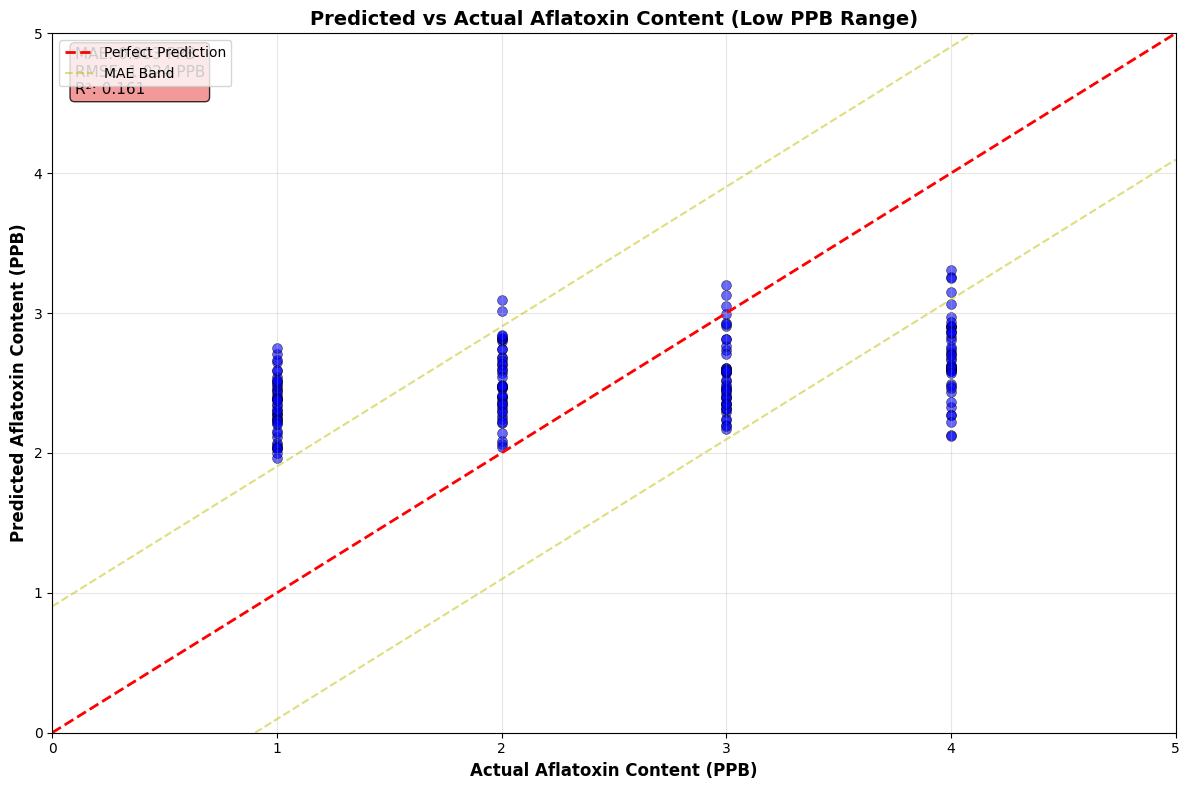

In [ ]:
# print("Step 8: Plotting training history...")

# # Gabungkan history
# acc = history_1.history['accuracy'] + history_2.history['accuracy']
# val_acc = history_1.history['val_accuracy'] + history_2.history['val_accuracy']
# loss = history_1.history['loss'] + history_2.history['loss']
# val_loss = history_1.history['val_loss'] + history_2.history['val_loss']

# epochs_range = range(1, len(acc) + 1)

# fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# # Plot Accuracy
# axes[0].plot(epochs_range, acc, 'b-', label='Training Accuracy')
# axes[0].plot(epochs_range, val_acc, 'r-', label='Validation Accuracy')
# axes[0].axvline(x=initial_epochs, color='g', linestyle='--', label='Fine-tuning Start')
# axes[0].set_xlabel('Epoch')
# axes[0].set_ylabel('Accuracy')
# axes[0].set_title('Training and Validation Accuracy')
# axes[0].legend()
# axes[0].grid(True, alpha=0.3)

# # Plot Loss
# axes[1].plot(epochs_range, loss, 'b-', label='Training Loss')
# axes[1].plot(epochs_range, val_loss, 'r-', label='Validation Loss')
# axes[1].axvline(x=initial_epochs, color='g', linestyle='--', label='Fine-tuning Start')
# axes[1].set_xlabel('Epoch')
# axes[1].set_ylabel('Loss')
# axes[1].set_title('Training and Validation Loss')
# axes[1].legend()
# axes[1].grid(True, alpha=0.3)

# plt.tight_layout()
# plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
# plt.show()

# print("✓ Training history saved to 'training_history.png'")

# print("\n" + "=" * 60)
# print("TRAINING DAN EVALUASI SELESAI!")
# print("=" * 60)

-------------------PERBANDINGAN NILAI-------------------

In [29]:
print("Step 12: Detailed Prediction Analysis on Test Set...")

import tensorflow as tf
import numpy as np
import pandas as pd 
import os
import pathlib
from tensorflow.keras.applications.resnet50 import preprocess_input

# Path dan variabel SETUP
base_dir = pathlib.Path(".") 
data_split_dir = base_dir / 'dataset_final'  # Pastikan path ini sesuai dengan struktur folder Anda
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# --- 1. LOAD MODEL ---
try:
    model = tf.keras.models.load_model('best_aflatoxin_classifier.keras')
    print("✅ Model terbaik berhasil dimuat.")
except Exception as e:
    print(f"❌ ERROR: Gagal memuat model: {e}")
    model = None

# --- 2. LOAD TEST DATA (Shuffle=False WAJIB untuk mapping filename) ---
print("Loading Test Data...")
test_ds_for_paths = tf.keras.preprocessing.image_dataset_from_directory(
    data_split_dir / 'test',
    labels="inferred",
    label_mode="int",
    color_mode="rgb",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  # PENTING!
)

filenames = [os.path.basename(p) for p in test_ds_for_paths.file_paths]
class_names = test_ds_for_paths.class_names
print(f"Found {len(filenames)} files belonging to {len(class_names)} classes.")

def preprocess_for_prediction(images, labels):
    images = tf.cast(images, tf.float32)
    images = preprocess_input(images)
    return images, labels

test_ds_processed = test_ds_for_paths.map(preprocess_for_prediction, num_parallel_calls=tf.data.AUTOTUNE)

# Ground Truth
y_true = np.concatenate([y for x, y in test_ds_for_paths], axis=0)

# Prediksi (cek model ada)
if model is None:
    raise RuntimeError("Model tidak dapat dimuat, periksa file best_aflatoxin_classifier.keras")

print("Melakukan prediksi...")
y_pred_proba = model.predict(test_ds_processed, verbose=1)

# Predicted class & confidence
y_pred = np.argmax(y_pred_proba, axis=1)
confidence = np.max(y_pred_proba, axis=1)

# 4. BUAT DATAFRAME
df_predictions = pd.DataFrame({
    'Filename': filenames,
    'Actual_Class': y_true,
    'Predicted_Class': y_pred,
    'Confidence': confidence,
    'Correct': y_true == y_pred
})

# Tambah label nama kelas (aman terhadap index out-of-range)
def safe_label(idx):
    try:
        return class_names[int(idx)]
    except Exception:
        return str(idx)

df_predictions['Actual_Label'] = df_predictions['Actual_Class'].apply(safe_label)
df_predictions['Predicted_Label'] = df_predictions['Predicted_Class'].apply(safe_label)

# Class difference
df_predictions['Class_Diff'] = np.abs(df_predictions['Actual_Class'] - df_predictions['Predicted_Class'])

# 5. SORTING
df_correct = df_predictions[df_predictions['Correct'] == True].copy()
df_best = df_correct.sort_values(by='Confidence', ascending=False)
df_incorrect = df_predictions[df_predictions['Correct'] == False].copy()
df_worst = df_incorrect.sort_values(by='Confidence', ascending=False)

# 6. OUTPUT
print("\n" + "="*60)
print("ANALISIS PERFORMA PREDIKSI (DATASET TEST)")
print("="*60)

print("\n✅ 10 HASIL PREDIKSI TERBAIK (Benar dengan Confidence Tertinggi):")
print("Model memprediksi dengan BENAR dan memiliki keyakinan tinggi.")
display_cols = ['Filename', 'Actual_Label', 'Predicted_Label', 'Confidence']
if len(df_best) > 0:
    try:
        print(df_best[display_cols].head(10).to_markdown(index=False, floatfmt=".4f"))
    except Exception:
        print(df_best[display_cols].head(10).to_string(index=False, float_format="{:.4f}".format))
else:
    print("Tidak ada prediksi yang benar.")

print("\n❌ 3 HASIL PREDIKSI TERBURUK (Salah dengan Confidence Tertinggi):")
print("Model memprediksi dengan SALAH namun memiliki keyakinan tinggi.")
display_cols_worst = ['Filename', 'Actual_Label', 'Predicted_Label', 'Confidence', 'Class_Diff']
if len(df_worst) > 0:
    try:
        print(df_worst[display_cols_worst].head(3).to_markdown(index=False, floatfmt=".4f"))
    except Exception:
        print(df_worst[display_cols_worst].head(3).to_string(index=False, float_format="{:.4f}".format))
else:
    print("✅ Tidak ada prediksi yang salah! Model sempurna.")

# 7. STATISTIK KLASIFIKASI
print("\n" + "="*60)
print("STATISTIK KLASIFIKASI")
print("="*60)

total = len(df_predictions)
correct = int(df_predictions['Correct'].sum())
incorrect = int(total - correct)
accuracy = correct / total if total > 0 else 0.0

print(f"\n📊 Total Samples: {total}")
print(f"📊 Correct Predictions: {correct} ({(correct/total*100) if total>0 else 0:.2f}%)")
print(f"📊 Incorrect Predictions: {incorrect} ({(incorrect/total*100) if total>0 else 0:.2f}%)")
print(f"📊 Accuracy: {accuracy:.4f}")

# 8. PER-CLASS ACCURACY (Confidence stats)
if len(confidence) > 0:
    print(f"\n📊 Confidence Statistics:")
    print(f"   Mean Confidence: {confidence.mean():.4f}")
    print(f"   Min Confidence:  {confidence.min():.4f}")
    print(f"   Max Confidence:  {confidence.max():.4f}")

    if len(df_correct) > 0:
        print(f"   Mean Confidence (Correct):   {df_correct['Confidence'].mean():.4f}")
    if len(df_incorrect) > 0:
        print(f"   Mean Confidence (Incorrect): {df_incorrect['Confidence'].mean():.4f}")

# 9. MISCLASSIFICATION SUMMARY
print(f"\n📊 Misclassification Summary:")
print("-" * 50)
if len(df_incorrect) > 0:
    misclass_summary = df_incorrect.groupby(['Actual_Label', 'Predicted_Label']).size().reset_index(name='Count')
    misclass_summary = misclass_summary.sort_values('Count', ascending=False)
    try:
        print(misclass_summary.to_markdown(index=False))
    except Exception:
        print(misclass_summary.to_string(index=False))
else:
    print("Tidak ada kesalahan klasifikasi!")

# 10. SIMPAN KE CSV
csv_path = "prediction_analysis_classification.csv"
df_predictions.to_csv(csv_path, index=False)
print(f"\n✅ Hasil lengkap disimpan ke: {csv_path}")

print("\n" + "="*60)
print("ANALISIS SELESAI!")
print("="*60)

Step 12: Detailed Prediction Analysis on Test Set...
✅ Model terbaik berhasil dimuat.
Loading Test Data...
Found 90 files belonging to 4 classes.
Found 90 files belonging to 4 classes.
Melakukan prediksi...
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step

ANALISIS PERFORMA PREDIKSI (DATASET TEST)

✅ 10 HASIL PREDIKSI TERBAIK (Benar dengan Confidence Tertinggi):
Model memprediksi dengan BENAR dan memiliki keyakinan tinggi.
  Filename Actual_Label Predicted_Label  Confidence
 4_42m.png            4               4      0.9288
  4_1m.png            4               4      0.9105
 4_27m.png            4               4      0.9057
 1_48m.png            1               1      0.8185
1_114m.png            1               1      0.8015
1_118m.png            1               1      0.7929
 4_47m.png            4               4      0.7791
 1_91m.png            1               1      0.7786
1_127m.png            1               1      0.7781
1_122m.png            1               1      0.7723

❌ 3 HASIL PRE